In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
! [ -e /content ] && pip install -Uqq fastai 

     |████████████████████████████████| 727kB 8.0MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 1.2MB 34.3MB/s 
     |████████████████████████████████| 194kB 55.0MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def search_images_ddg(key,max_n=200):
     """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
        (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api)
     """
     url        = 'https://duckduckgo.com/'
     params     = {'q':key}
     res        = requests.post(url,data=params)
     searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
     if not searchObj: print('Token Parsing Failed !'); return
     requestUrl = url + 'i.js'
     headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'}
     params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
     urls       = []
     while True:
         try:
             res  = requests.get(requestUrl,headers=headers,params=params)
             data = json.loads(res.text)
             for obj in data['results']:
                 urls.append(obj['image'])
                 max_n = max_n - 1
                 if max_n < 1: return L(set(urls))     # dedupe
             if 'next' not in data: return L(set(urls))
             requestUrl = url + data['next']
         except:
             pass

In [ ]:
cobra_species_str = "samar, indian, cape, equitorial spitting"
cobra_species = cobra_species_str.replace(', ', ',').replace(' ', '_').split(',')

In [4]:
path = Path('drive/MyDrive/MyMLProjects/Chapter2/cobras')

In [ ]:
for specie in cobra_species:
  dest = (path/specie)
  dest.mkdir(exist_ok=True)
  results = search_images_ddg(specie.replace('_', ' ')+' cobra', max_n=300)
  download_images(dest, urls=results)

In [13]:
fns = get_image_files(path)
fns

(#347) [Path('drive/MyDrive/MyMLProjects/Chapter2/cobras/samar/00000002.jpg'),Path('drive/MyDrive/MyMLProjects/Chapter2/cobras/samar/00000001.jpg'),Path('drive/MyDrive/MyMLProjects/Chapter2/cobras/samar/00000008.jpg'),Path('drive/MyDrive/MyMLProjects/Chapter2/cobras/samar/00000007.jpg'),Path('drive/MyDrive/MyMLProjects/Chapter2/cobras/samar/00000004.jpg'),Path('drive/MyDrive/MyMLProjects/Chapter2/cobras/samar/00000010.jpg'),Path('drive/MyDrive/MyMLProjects/Chapter2/cobras/samar/00000020.jpg'),Path('drive/MyDrive/MyMLProjects/Chapter2/cobras/samar/00000016.jpg'),Path('drive/MyDrive/MyMLProjects/Chapter2/cobras/samar/00000012.jpg'),Path('drive/MyDrive/MyMLProjects/Chapter2/cobras/samar/00000018.jpg')...]

In [14]:
failed = verify_images(fns)
failed

(#0) []

In [7]:
failed.map(Path.unlink)

(#0) []

In [23]:
cobras = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = cobras.dataloaders(path)

In [27]:
learner = cnn_learner(dls, resnet18, metrics=error_rate)

In [28]:
learner.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.964263,0.828649,0.304348,00:06


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.370347,0.250520,0.115942,00:06
1,0.256232,0.119097,0.028986,00:06
2,0.184208,0.123974,0.028986,00:07
3,0.149271,0.119595,0.014493,00:06
4,0.127818,0.111482,0.014493,00:06


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

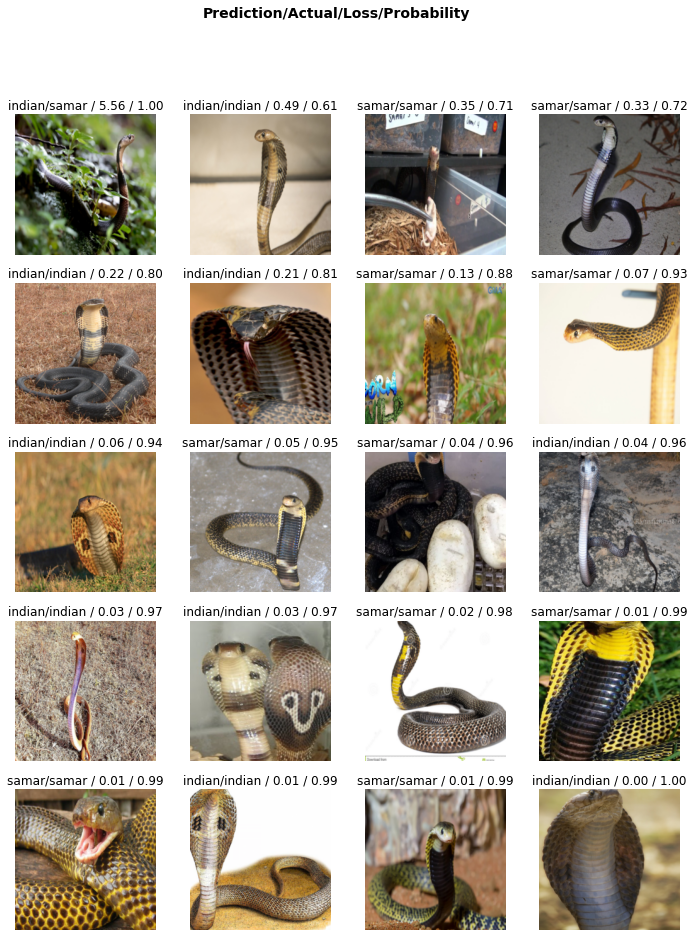

In [19]:
interp.plot_top_losses(20, nrows=5)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


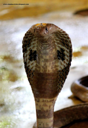

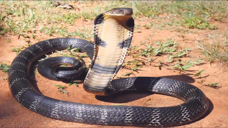

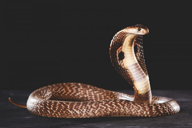

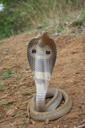

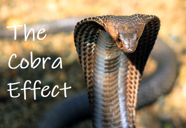

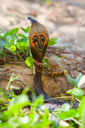

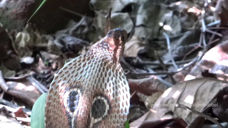

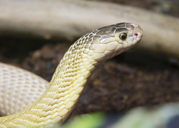

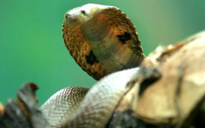

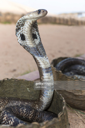

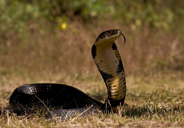

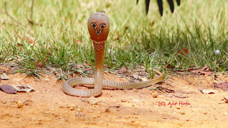

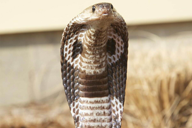

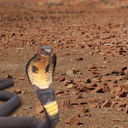

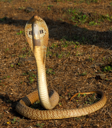

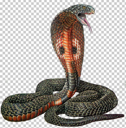

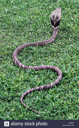

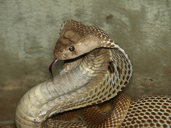

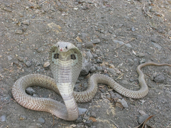

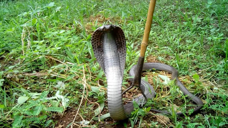

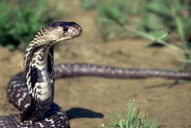

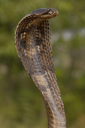

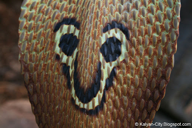

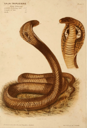

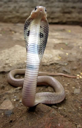

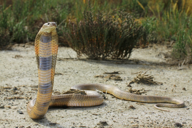

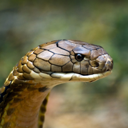

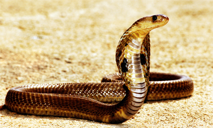

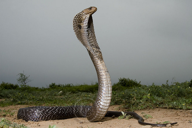

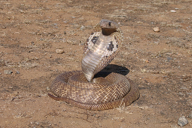

In [ ]:
cleaner = ImageClassifierCleaner(learner)
cleaner

In [ ]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Error: ignored